Apply P3INN on Core 2 data to obtain many quantiles for it. FINN is then trained on these quantiles (Data-SPAN) to obtain many retardations. Including to the retardations, FINN will compute the C field for each quantile. Then I also have a UQ estimate for C.

In [2]:
import shutil
import importlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import lib
import p3inn

importlib.reload(lib)
importlib.reload(p3inn)

<module 'p3inn' from '/Users/r/Documents/stud/ss24/finnpinn/src/p3inn/__init__.py'>

# Run

In [3]:
data_out_root = Path("../data_out").resolve()
assert data_out_root.exists()
pi3nn_root = data_out_root / "p3inn"
finn_root = data_out_root / "finn"
pi3nn_root.mkdir(exist_ok=True, parents=True)
finn_root.mkdir(exist_ok=True, parents=True)

In [4]:
data_core2_df = lib.load_exp_data(name="Core 2")
display(data_core2_df.head())

,time,c_diss
0,0.000000,0.000000
1,0.838329,0.000096
2,1.377912,0.000062
3,1.879996,0.000061
4,2.379996,0.000052


### PI3NN on experimental data to obtain PIs for different quantiles

In [5]:
# x = data_core2_df["time"].to_numpy().squeeze()
# plt.figure()
# plt.plot(x, data_core2_df["c_diss"], ".")
# plt.plot(x, net_mean(x), "x")
# res = data_core2_df["c_diss"].to_numpy().squeeze() - net_mean(x).squeeze()
# _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
# ax1.plot(x[res>0], res[res>0], "x")
# ax2.plot(x[res<=0], res[res<=0], "x")
# plt.show()

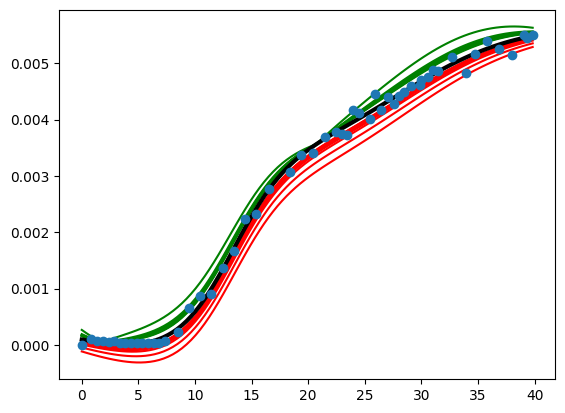

In [6]:
ref_dir = p3inn.P3innDir(Path("../data_out copy 20102024/p3inn/core2"))
for q, bound_up, bound_down in ref_dir.iter_pred_PIs():
    plt.plot(ref_dir.x_eval.load(), bound_up, "g-")
    plt.plot(ref_dir.x_eval.load(), bound_down, "r-")
plt.plot(ref_dir.x_eval.load(), ref_dir.pred_median.load(), "k-", lw=3)
plt.scatter(ref_dir.x_data.load(), ref_dir.y_data.load(), zorder=10)
plt.show()

In [7]:
p3inn_core2_dir = p3inn.P3innDir(pi3nn_root / "core2")

[0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675
 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95 ]
TrainingParams(max_epochs=50000, initial_learning_rate=0.1, batch_size=8, activation='tanh', loss_fun='mse', optimizer='adam', validation_fraction=0.2, stop_early=True, n_neurons_per_layer=[32]) TrainingParamsStd(max_epochs=1700, initial_learning_rate=0.01, batch_size=None, activation='tanh', loss_fun='mse', optimizer='adam', validation_fraction=0.1, stop_early=False, n_neurons_per_layer=[64]) ExperimentParams(out_dir=PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/p3inn/core2'), x_data_path=PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/p3inn/core2/x_data.npy'), y_data_path=PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/p3inn/core2/y_data.npy'), quantiles=[0.1, 0.125, 0.15, 0.175, 0.2, 0.22499999999999998, 0.25, 0.275, 0.3, 0.32499999999999996

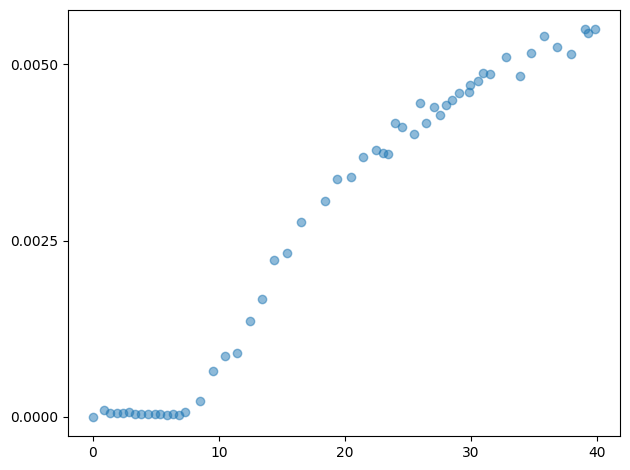

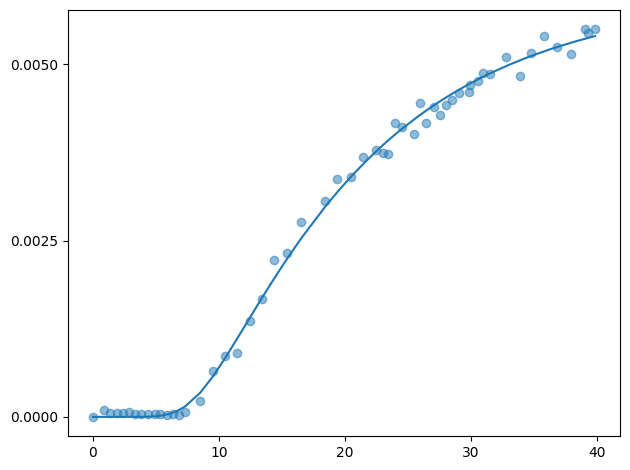

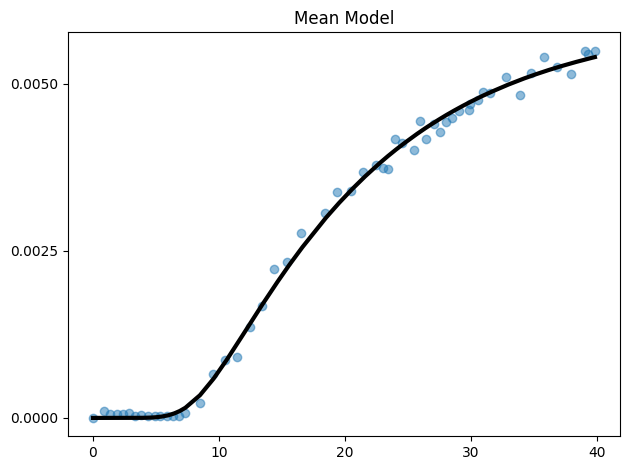

median_shift=1.7520734085160675e-05


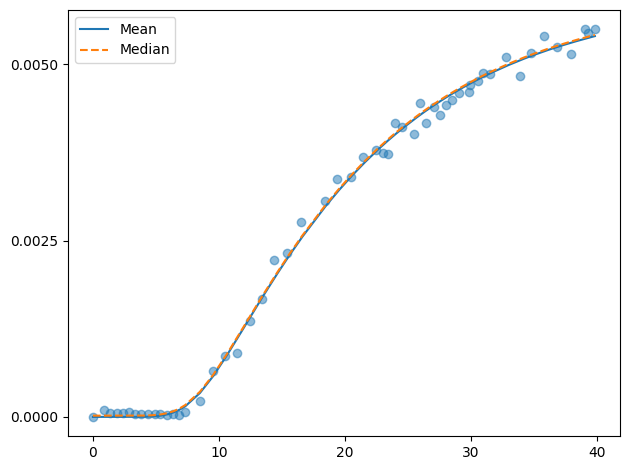

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


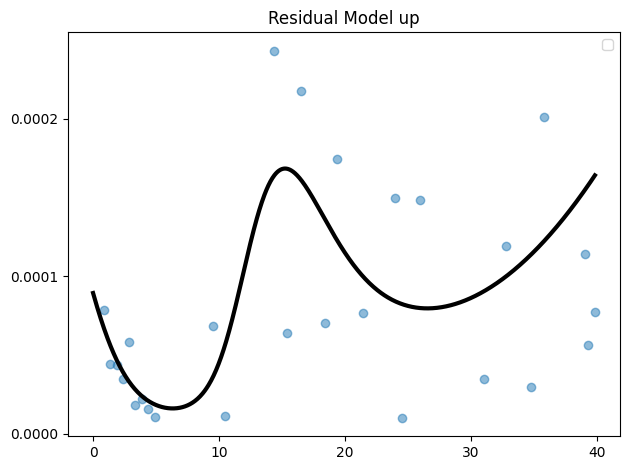

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


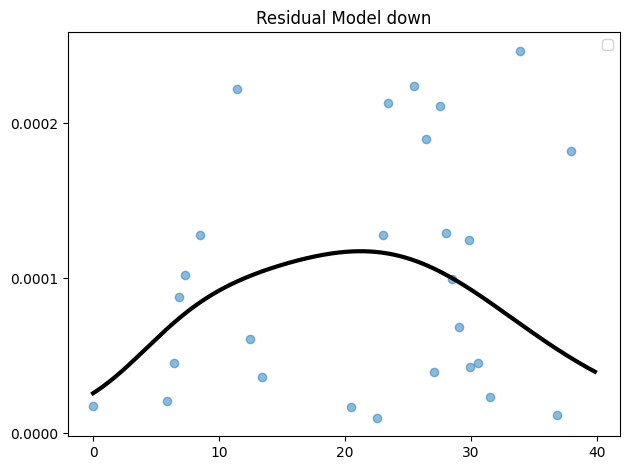

Quantile: 0.1
    c_up=0.298023
    c_down=0.238419

Saving quantiles...
    PI contains 12.7%

Quantile: 0.125
    c_up=0.298023
    c_down=0.238419

Saving quantiles...
    PI contains 12.7%

Quantile: 0.15
    c_up=0.357628
    c_down=0.298023

Saving quantiles...
    PI contains 16.4%

Quantile: 0.175
    c_up=0.38743
    c_down=0.327826

Saving quantiles...
    PI contains 20.0%

Quantile: 0.2
    c_up=0.38743
    c_down=0.327826

Saving quantiles...
    PI contains 20.0%

Quantile: 0.22499999999999998
    c_up=0.417233
    c_down=0.357628

Saving quantiles...
    PI contains 23.6%

Quantile: 0.25
    c_up=0.476837
    c_down=0.417233

Saving quantiles...
    PI contains 27.3%

Quantile: 0.275
    c_up=0.536442
    c_down=0.476837

Saving quantiles...
    PI contains 30.9%

Quantile: 0.3
    c_up=0.536442
    c_down=0.476837

Saving quantiles...
    PI contains 30.9%

Quantile: 0.32499999999999996
    c_up=0.596046
    c_down=0.596046

Saving quantiles...
    PI contains 36.4%

Qu

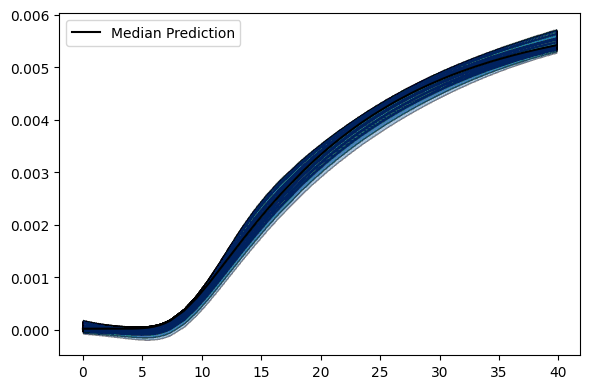

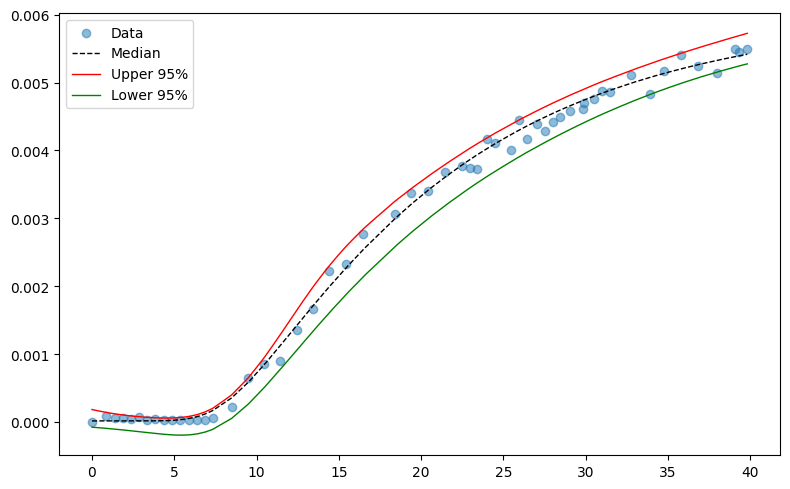

In [13]:
p3inn_core2_dir = p3inn.P3innDir(pi3nn_root / "core2")
# shutil.rmtree(p3inn_core2_dir.path.absolute())
# p3inn_core2_dir = p3inn.P3innDir(pi3nn_root / "core2")
p3inn_core2_dir.x_data.save(data_core2_df["time"].to_numpy().reshape(-1, 1))
p3inn_core2_dir.y_data.save(data_core2_df["c_diss"].to_numpy().reshape(-1, 1))

quantiles = np.linspace(0.1, 0.95, 35, endpoint=True)
print(quantiles)

finn_core2_dir = lib.FinnDir(Path("../data_out/finn/core2"))
fp = np.load(finn_core2_dir.get_data_pred_path(finn_core2_dir.best_epoch))
xp = np.load(finn_core2_dir.t_train_path)


def net_mean(x):
    y = np.interp(x, xp, fp).reshape(-1, 1)
    return y


p3inn.pi3nn_compute_PI_and_mean(
    out_dir=p3inn_core2_dir.path,
    quantiles=quantiles.tolist(),
    visualize=True,
    passed_net_mean=net_mean,
    # max_iter=10000,
    load_from_dir=True,
)

### FINN on all quantiles to obtain retardations

In [8]:
finn_exp_root = finn_root / "p3inn_core2_new_multiprocessing"
finn_exp_root

PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing')

In [9]:
conf_core2 = lib.load_exp_conf(name="Core 2")
display(conf_core2)

{'D': 2.0045664000000002e-05,
 'por': 0.288,
 'rho_s': 1957.0,
 'X': 0.026034999999999996,
 'T': 39.824440010000004,
 'Nx': 20.0,
 'Nt': 55.0,
 'sample_radius': 0.02375,
 'Q': 0.00010435199999999999,
 'solubility': 1.6,
 'Dirichlet': 0.0,
 'Cauchy': 1.0}

In [10]:
from pathlib import Path

# Prepare a list of commands to run in parallel
commands = []

for quantile, bound_up, bound_down in p3inn_core2_dir.iter_pred_PIs():
    for bound_type, bound in [("up", bound_up), ("down", bound_down)]:
        bound_file = Path(
            f"/tmp/bound_{bound_type}_{quantile:g}.npy"
        )  # Save bound data to file
        np.save(bound_file, bound)

        finn_dir = lib.FinnDir(finn_exp_root / f"{bound_type}_{quantile:g}")
        # print(finn_dir.path.resolve())

        command = f"python3 run_finn_core2.py {finn_dir.path.resolve()} {bound_file} > ../data_out/logs/{quantile:g}_{bound_type}.txt"
        commands.append(command)

In [11]:
# Write all commands to a temporary file (input for GNU Parallel)
commands_file = Path("/tmp/parallel_commands.txt")
with open(commands_file, "w") as f:
    f.write("\n".join(commands))
print(commands_file.resolve())

/private/tmp/parallel_commands.txt


In [12]:
command = f"cat {commands_file} | parallel -j 6 --bar"
# subprocess.run(command, check=True, shell=True)
print(command)

cat /tmp/parallel_commands.txt | parallel -j 6 --bar


In [13]:
!cat /tmp/parallel_commands.txt

python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.1 /tmp/bound_up_0.1.npy > ../data_out/logs/0.1_up.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.1 /tmp/bound_down_0.1.npy > ../data_out/logs/0.1_down.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.125 /tmp/bound_up_0.125.npy > ../data_out/logs/0.125_up.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.125 /tmp/bound_down_0.125.npy > ../data_out/logs/0.125_down.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/up_0.15 /tmp/bound_up_0.15.npy > ../data_out/logs/0.15_up.txt
python3 run_finn_core2.py /Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new_multiprocessing/down_0.15 /tmp/bou